In [ ]:
# --- SETUP ---
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, sum
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Start Spark session
spark = SparkSession.builder \
    .appName("AccidentSeverityPrediction") \
    .master("local") \
    .getOrCreate()

In [ ]:
# --- LOAD DATA ---
df = spark.read.csv("Final_Dataset.csv", header=True, inferSchema=True)
print(f"Number of rows in dataset: {df.count()}")
df.show(1, vertical=True)
df.printSchema()

Number of rows in dataset: 7728394
-RECORD 0-----------------------------------------
 ID                        | A-3426647            
 Source                    | Source1              
 Severity                  | 2                    
 Start_Time                | 2016-12-16 16:09:33  
 End_Time                  | 2016-12-16 22:09:33  
 Start_Lat                 | 44.83152000000001    
 Start_Lng                 | -91.45307            
 End_Lat                   | 44.83802             
 End_Lng                   | -91.4432             
 Distance(mi)              | 0.66                 
 Description               | At WI-312/North X... 
 Street                    | US-53 N              
 City                      | Eau Claire           
 County                    | Eau Claire           
 State                     | WI                   
 Zipcode                   | 54703                
 Country                   | US                   
 Timezone                  | US/Central        

In [ ]:
# --- HANDLE MISSING VALUES ---
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-------------------------+-----------+-----------+---------+-----------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming

In [ ]:
# --- SELECT FEATURES ---
# Numerical features
num_features = [
    "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)", "Distance_km",
    "Accident_Duration_Minutes", "Hour_of_Day", "Rush_Hour"
]

# Boolean features
bool_features = [
    "Amenity", "Bump", "Crossing", "Junction", "Traffic_Signal",
    "Traffic_Calming", "No_Exit", "Railway", "Roundabout", "Station", "Stop"
]

# Categorical features (to be indexed)
cat_features = ["Weather_Condition", "Wind_Direction", "Day_of_Week", "Sunrise_Sunset"]

# Drop rows with nulls in selected features
df = df.dropna(subset=num_features + bool_features + cat_features + ["Severity"])


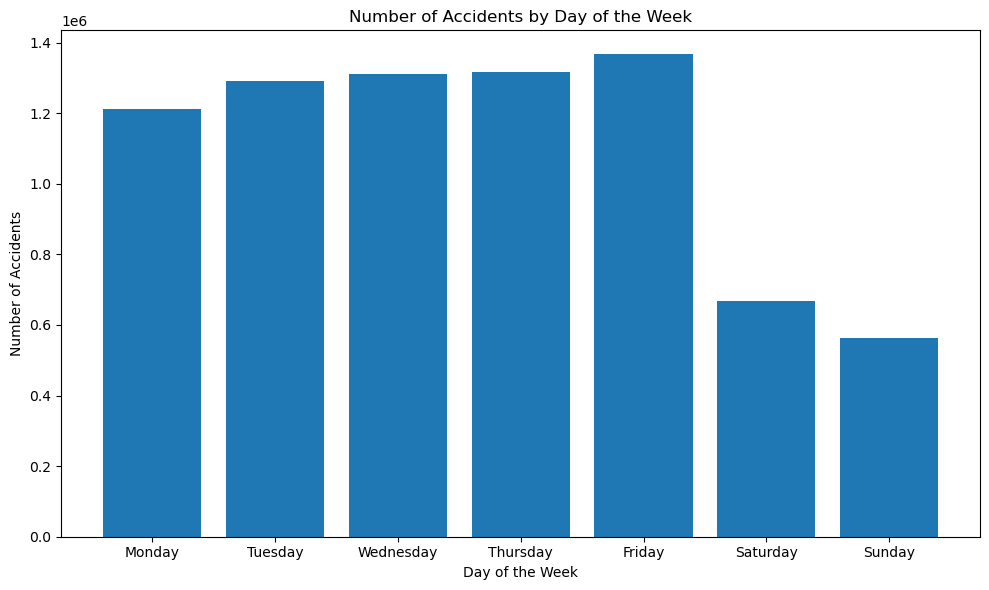

In [ ]:
# --- VISUALIZATION: Number of Accidents by Day of the Week ---
# Count number of accidents per day of week
day_counts = df.groupBy("Day_of_Week").count().toPandas()

# Sort days of the week manually for correct order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts["Day_of_Week"] = pd.Categorical(day_counts["Day_of_Week"], categories=day_order, ordered=True)
day_counts = day_counts.sort_values("Day_of_Week")

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(day_counts["Day_of_Week"], day_counts["count"])
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents by Day of the Week")
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import col, count, round

# Total number of accidents
total_count = df.count()

# Count and percentage of each severity class
severity_distribution = (
    df.groupBy("Severity")
      .agg(count("*").alias("Count"))
      .withColumn("Percentage", round((col("Count") / total_count) * 100, 2))
      .orderBy("Severity")
)

# Show the result
severity_distribution.show()


+--------+-------+----------+
|Severity|  Count|Percentage|
+--------+-------+----------+
|       1|  67366|      0.87|
|       2|6156981|     79.67|
|       3|1299337|     16.81|
|       4| 204710|      2.65|
+--------+-------+----------+



In [ ]:

# Index categorical features
indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="skip") for c in cat_features]

# Assemble features
final_features = num_features + bool_features + [c + "_indexed" for c in cat_features]
assembler = VectorAssembler(inputCols=final_features, outputCol="features", handleInvalid="skip")

# Index the label column
label_indexer = StringIndexer(inputCol="Severity", outputCol="label", handleInvalid="skip")

# Initialize Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxBins=200)

# Create ML pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, rf])

# Split data
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction", "probability").show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       0.0|[0.79781062788718...|
|  0.0|       0.0|[0.83942135629237...|
|  1.0|       0.0|[0.74402682348829...|
|  1.0|       0.0|[0.80132761570921...|
|  1.0|       0.0|[0.72215721674029...|
+-----+----------+--------------------+
only showing top 5 rows



In [ ]:
# --- EVALUATION ---

# Accuracy
accuracy_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_eval.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.3f}")

# F1 Score
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_eval.evaluate(predictions)
print(f"F1 Score: {f1:.3f}")

Test Accuracy: 0.797
F1 Score: 0.707


In [ ]:
#StringIndexer output
index_model = label_indexer.fit(df)
print(index_model.labels)

['2', '3', '4', '1']


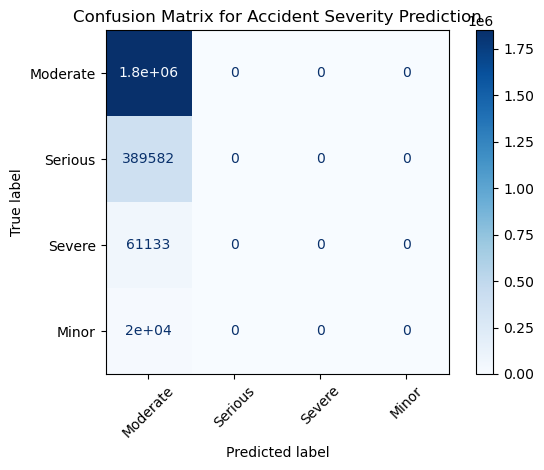

In [ ]:
# --- CONFUSION MATRIX ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictions to Pandas DataFrame for evaluation
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Correct labels according to StringIndexer output ['2', '3', '4', '1']
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Moderate", "Serious", "Severe", "Minor"]
)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Accident Severity Prediction")
plt.tight_layout()
plt.show()


In [ ]:
# --- CLASSIFICATION REPORT ---
from sklearn.metrics import classification_report

# Generate and display the classification report
report = classification_report(
    y_true, y_pred,
    target_names=["Moderate", "Serious", "Severe", "Minor"],
    zero_division=0
)

print("Classification Report (Precision, Recall, F1-score per class):\n")
print(report)


Classification Report (Precision, Recall, F1-score per class):

              precision    recall  f1-score   support

    Moderate       0.80      1.00      0.89   1848559
     Serious       0.00      0.00      0.00    389582
      Severe       0.00      0.00      0.00     61133
       Minor       0.00      0.00      0.00     20159

    accuracy                           0.80   2319433
   macro avg       0.20      0.25      0.22   2319433
weighted avg       0.64      0.80      0.71   2319433



Top 10 Important Features:
                      Feature  Importance
6                 Distance_km    0.283587
7   Accident_Duration_Minutes    0.221849
12                   Crossing    0.120539
21  Weather_Condition_indexed    0.093319
22     Wind_Direction_indexed    0.082710
5           Precipitation(in)    0.070689
14             Traffic_Signal    0.063182
2                Pressure(in)    0.020457
23        Day_of_Week_indexed    0.018650
13                   Junction    0.008488


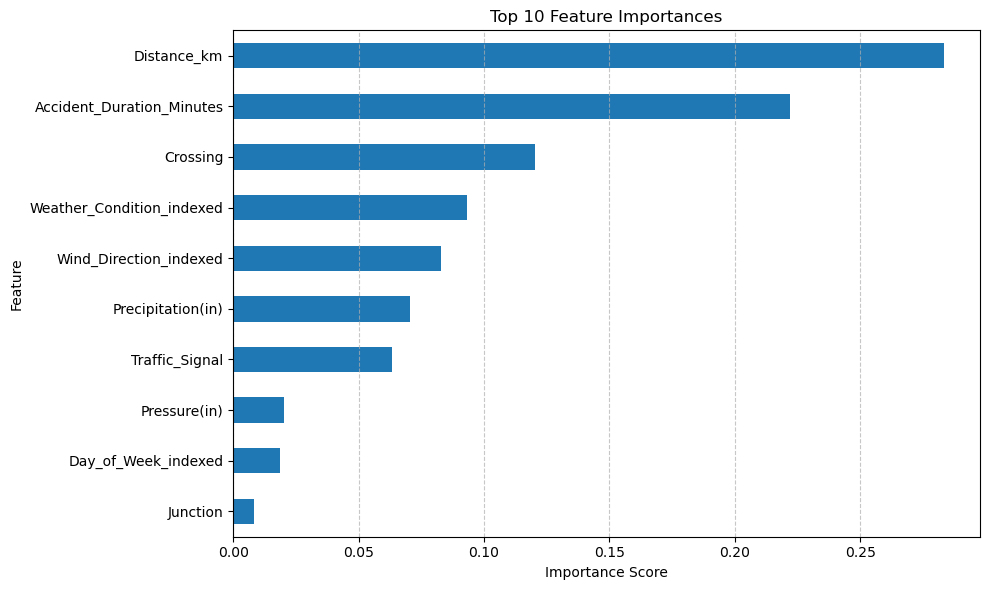

In [ ]:
# --- FEATURE IMPORTANCES ---
# Get trained RF model
rf_model = model.stages[-1]
importances = rf_model.featureImportances.toArray()

# Create DataFrame for feature importance
feature_names = final_features
importance_df = pd.DataFrame(list(zip(feature_names, importances)), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display top 10
print("Top 10 Important Features:")
print(importance_df.head(10))  # Use print instead of display for compatibility

# Plot top 10 features horizontally
ax = importance_df.head(10).plot(
    kind="barh",
    x="Feature",
    y="Importance",
    figsize=(10, 6),
    title="Top 10 Feature Importances",
    legend=False
)

# Invert y-axis to have the highest at the top
plt.gca().invert_yaxis()

plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
